# Combined ML Pipeline for Scientific Tweet Analysis

Groupe 12
Vargas Vila Daniel 22006745
Moussa Etienne 22108464
Salhi Nina 22115492

This notebook combines all three tasks:
1. Science Related Classification
2. CLAIM/REF vs CONTEXT Classification
3. Multi-label Classification

In [15]:
# Common imports for all tasks
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, f1_score, precision_score,
    recall_score, accuracy_score, confusion_matrix, make_scorer
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect
import joblib
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

import os
# Création d'un répertoire local au cas où les chemins par défaut posent problème
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)
# Ajout manuel au chemin
nltk.data.path.append(nltk_data_dir)
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

#Librairies Scikit-learn
from sklearn.manifold import TSNE  # Réduction de dimensions avec T-SNE
from sklearn.decomposition import PCA  # Réduction de dimensions avec ACP

from umap import UMAP


[nltk_data] Downloading package punkt to /home/etienne/Bureau/ML/Machi
[nltk_data]     ne_learning/Projet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/etienne/Bureau/ML/M
[nltk_data]     achine_learning/Projet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/etienne/Bureau/ML/Mac
[nltk_data]     hine_learning/Projet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Task 1: Science Related Classification

Pipeline for classifying tweets as science-related or not.

In [16]:
class ModelPipeline1:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Naïve Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "SVM": SVC(kernel='linear'),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score),
            "Recall": make_scorer(recall_score),
            "F1 Score": make_scorer(f1_score)
        }
        self.results = {}
        self.best_model = None
        self.vectorizer = None

    def preprocess_data(self, df, with_preprocessing=False):
        """Preprocess data based on the phase"""
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
        
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
        
        if with_preprocessing:
            try:
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            except OSError:
                print("Installing spaCy models...")
                import os
                os.system("python -m spacy download fr_core_news_sm")
                os.system("python -m spacy download en_core_web_sm")
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            
            def clean_and_lemmatize_multilang(text):
                text = text.lower()
                text = re.sub(r"http\S+", "URL", text)
                text = re.sub(r"@\w+", "MENTION", text)
                text = re.sub(r"#(\w+)", r"\1", text)
                text = re.sub(r"[^\w\s:]", "", text)
                try:
                    lang = detect(text)
                except:
                    lang = "en"
                doc = nlp_fr(text) if lang == "fr" else nlp_en(text)
                return " ".join([token.lemma_ for token in doc if not token.is_stop])
            
            df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
            text_column = 'text_clean'
        else: 
            text_column = 'text'
            
        return df, text_column

    def prepare_features(self, df, text_column, stopwords=None, max_features=10000):
        vectorizer = TfidfVectorizer(
            min_df=5,
            max_df=0.95,
            stop_words=stopwords,
            lowercase=True,
            ngram_range=(1, 2),
            max_features=max_features
        ) if stopwords else TfidfVectorizer(max_features=max_features)
        
        X_text = df[text_column]
        X_tfidf = vectorizer.fit_transform(X_text)
        self.vectorizer = vectorizer
        
        extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)
        X_final = scipy.sparse.hstack([X_tfidf, X_extra])
        
        return X_final, vectorizer

    def train_and_evaluate(self, X, y, phase_name):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []
        best_f1 = 0
        
        for name, model in self.models.items():
            print(f"\n🔍 Training model: {name}")
            
            fold_metrics = {
                "Accuracy": [],
                "Precision": [],
                "Recall": [],
                "F1": []
            }
            
            for fold, (train_idx, test_idx) in enumerate(cv.split(X.toarray() if scipy.sparse.issparse(X) else X, y), 1):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                fold_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics["Precision"].append(precision_score(y_test, y_pred))
                fold_metrics["Recall"].append(recall_score(y_test, y_pred))
                fold_metrics["F1"].append(f1_score(y_test, y_pred))
                
                if fold == cv.n_splits:
                    plt.figure(figsize=(6, 5))
                    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Confusion Matrix - {name} ({phase_name})')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()
            
            metrics = {
                "Model": name,
                "Phase": phase_name
            }
            
            for metric_name, scores in fold_metrics.items():
                metrics[metric_name] = np.mean(scores)
                metrics[f"{metric_name}_Std"] = np.std(scores)
                print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            
            if metrics["F1"] > best_f1:
                best_f1 = metrics["F1"]
                self.best_model = {
                    'name': name,
                    'model': model,
                    'vectorizer': self.vectorizer
                }
            
            results.append(metrics)
        
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'model_results_task1_{phase_name.lower().replace(" ", "_")}.csv', index=False)
        return results_df

    def save_best_model(self):
        if self.best_model is None:
            print("No best model found. Please run train_and_evaluate first.")
            return
        
        print(f"\nSaving best model: {self.best_model['name']}")
        joblib.dump(self.best_model, 'best_model_task1.joblib')
        print("Model saved successfully!")

    def optimize_mlp_with_optuna(self, X, y, n_trials=30):
        def objective(trial):
            hidden_layer_sizes = trial.suggest_categorical(
                "hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)]
            )
            learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    
            model = Pipeline([
                ("scaler", StandardScaler(with_mean=False)),
                ("mlp", MLPClassifier(
                    hidden_layer_sizes=hidden_layer_sizes,
                    learning_rate_init=learning_rate_init,
                    max_iter=500,
                    random_state=42
                ))
            ])
    
            # Cross-validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
            return scores.mean()

def run_task1():
    """Execute Task 1: Science Related Classification"""
    print("\n=== Task 1: Science Related Classification ===")
    
    # Load data
    print("\nLoading data...")
    df = pd.read_csv('scitweets_balanced.tsv', sep='\t')
    df.dropna(subset=['text'], inplace=True)
    y = df['science_related']
    
    # Initialize and run pipeline
    pipeline = ModelPipeline1()
    print("\n=== Training Model ===")
    df_prepared, text_column = pipeline.preprocess_data(df.copy(), with_preprocessing=True)
    
    # Load French stopwords
    stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
    french_stopwords = stopwords_df.index.tolist()
    
    # Prepare features and train
    X_prepared, _ = pipeline.prepare_features(df_prepared, text_column, french_stopwords)
    results = pipeline.optimize_mlp_with_optuna(X_prepared, y, "Full_Training")
    
    # Save the best model
    pipeline.save_best_model()
    
    # Plot final results
    plt.figure(figsize=(15, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 4, i)
        sns.barplot(data=results, x='Model', y=metric)
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Task 2: CLAIM/REF vs CONTEXT Classification

Pipeline for classifying tweets between CLAIM/REF and CONTEXT categories.

In [17]:
class ModelPipeline2:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Multinomial NB": MultinomialNB(),
            "Random Forest": RandomForestClassifier(),
            "SVM": SVC(),
            "SVM linear": LinearSVC(),
            "KNN": KNeighborsClassifier(),
            "AdaBoost": AdaBoostClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score),
            "Recall": make_scorer(recall_score),
            "F1 Score": make_scorer(f1_score)
        }
        self.results = {}
        self.best_model = None
        self.vectorizer = None

    def clean_text_light(self, text):
        text = text.lower()
        text = re.sub(r"http\S+", "URL", text)
        text = re.sub(r"@\w+", "MENTION", text)
        text = re.sub(r"#(\w+)", r"\1", text)
        text = re.sub(r":[^:\s]+:", "EMOJI", text)
        return text

    def analyze_data(self, df):
        df_sci = df[df["science_related"] == 1]

        df_context = df_sci[df_sci["scientific_context"] == 1.0]
        df_context_unic = df_context[(df_context["scientific_claim"] == 0.0) & (df_context["scientific_reference"] == 0.0)]
        df_claim_ref = df_sci[(df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0)]
        df_claim_ou_ref = df_sci[(df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)]
        df_claim_ou_ref_unic = df_claim_ou_ref[df_claim_ou_ref["scientific_context"] == 0.0]
        df_claim_ref_context = df_sci[
            (df_sci["scientific_claim"] == 1.0) & 
            (df_sci["scientific_reference"] == 1.0) & 
            (df_sci["scientific_context"] == 1.0)
        ]

        counts = {
            "CLAIM ou REF (avec context possible)": len(df_claim_ou_ref),
            "CLAIM ou REF (sans context)": len(df_claim_ou_ref_unic),
            "CONTEXT uniquement (sans claim ou ref)": len(df_context_unic),
            "CONTEXT (avec claim ou ref)": len(df_context),
            "CLAIM et REF et CONTEXT": len(df_claim_ref_context)
        }

        df_counts = pd.DataFrame(list(counts.items()), columns=["Catégorie", "Nombre"])

        plt.figure(figsize=(11, 7))
        bars = plt.bar(df_counts["Catégorie"], df_counts["Nombre"], color=["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#E9967A"])
        plt.title("Répartition des types d'assertions scientifiques", fontsize=14)
        plt.xlabel("Type d'assertion", fontsize=12)
        plt.ylabel("Nombre de tweets", fontsize=12)
        plt.xticks(rotation=15)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

        return df_sci

    def create_label(self, df_sci):
        df_sci = df_sci.copy()
        df_sci["label"] = df_sci.apply(
            lambda row: 0 if (row["scientific_context"] == 1.0 and 
                             row["scientific_claim"] == 0.0 and 
                             row["scientific_reference"] == 0.0)
            else 1,
            axis=1
        )
        print("\n Label distribution:")
        print(df_sci["label"].value_counts())
        return df_sci

    def MyCleanText(self, X,
                    lowercase=True,
                    removestopwords=False,
                    removedigit=True,
                    getstemmer=False,
                    getlemmatisation=True,
                    stop_words=None):

        sentence = str(X)
        sentence = re.sub(r'[^\w\s]', ' ', sentence)
        sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

        tokens = word_tokenize(sentence)

        if lowercase:
            tokens = [token.lower() for token in tokens]
        tokens = [word for word in tokens if word.isalnum()]

        if removedigit:
            tokens = [word for word in tokens if not word.isdigit()]

        if removestopwords and stop_words is not None:
            tokens = [word for word in tokens if word not in stop_words]

        if getlemmatisation:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens]

        if getstemmer:
            ps = PorterStemmer()
            tokens = [ps.stem(word) for word in tokens]

        return ' '.join(tokens)

    def preprocess_data(self, df, use_advanced_cleaning=False):
        df['tweet_text'] = df['text'].apply(lambda x: emoji.demojize(x))

        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['tweet_text'].str.contains(r':[^:\s]+:', regex=True)

        if use_advanced_cleaning:
            print("🧹 Nettoyage avancé + lemmatisation...")
            df['text_clean'] = df['tweet_text'].apply(self.clean_text_light)
            stop_words = set(stopwords.words('english'))
            df['text_clean'] = df['text_clean'].apply(lambda x: self.MyCleanText(
                x,
                lowercase=True,
                removestopwords=False,
                removedigit=True,
                getstemmer=False,
                getlemmatisation=True,
                stop_words=stop_words
            ))
        else:
            print("🧽 Nettoyage simple (light)...")
            df['text_clean'] = df['tweet_text'].apply(self.clean_text_light)

        df.dropna(subset=['text_clean'], inplace=True)
        return df, 'text_clean'

    def add_text_features(self, df):
        df['tweet_text'] = df['text'].apply(lambda x: emoji.demojize(x))
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['tweet_text'].str.contains(r':[^:\s]+:', regex=True)
        return df

    def vectorize_text(self, df, use_cleaned=False):
        text_column = 'text_clean' if use_cleaned and 'text_clean' in df.columns else 'tweet_text'
        df = df.dropna(subset=[text_column])
        X_text = df[text_column]

        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 2),
            max_df=0.9,
            min_df=2
        )
        X_tfidf = vectorizer.fit_transform(X_text)
        self.vectorizer = vectorizer

        extra_features = df[['has_url', 'has_mention', 'has_hashtag']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)

        X_full = scipy.sparse.hstack([X_tfidf, X_extra])
        print("🔢 Taille TF-IDF :", X_tfidf.shape)
        print("➕ Taille features binaires :", X_extra.shape)
        print("📐 Taille finale :", X_full.shape)

        return X_tfidf, X_full, vectorizer

    def extract_cleaned_features(self, X_tfidf, vectorizer):
        feature_names = vectorizer.get_feature_names_out()
        tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

        def get_token_category(token):
            if token.isdigit():
                return 'numeric'
            if re.match(r'^\d+(am|pm|s|h|min|sec|hour|years)?$', token.lower()):
                return 'timestamp'
            if re.match(r'^[a-zA-Z]+$', token):
                return 'valid'
            return 'other'

        token_categories = {token: get_token_category(token) for token in tfidf_df.columns}
        valid_tokens = [t for t, c in token_categories.items() if c == 'valid']
        numeric_tokens = [t for t, c in token_categories.items() if c == 'numeric']
        timestamp_tokens = [t for t, c in token_categories.items() if c == 'timestamp']

        tfidf_df['numeric'] = tfidf_df[numeric_tokens].sum(axis=1) if numeric_tokens else 0
        tfidf_df['timestamp'] = tfidf_df[timestamp_tokens].sum(axis=1) if timestamp_tokens else 0
        tfidf_cleaned = tfidf_df[valid_tokens + ['numeric', 'timestamp']]
        X_cleaned = scipy.sparse.csr_matrix(tfidf_cleaned.values)

        print("🧼 Matrice nettoyée :", tfidf_cleaned.shape)
        return X_cleaned, tfidf_cleaned

    def evaluate_models(self, X, y):
        models = {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Multinomial NB": MultinomialNB(),
            "Random Forest": RandomForestClassifier(),
            "SVM": SVC(),
            "SVM linear": LinearSVC(),
            "KNN": KNeighborsClassifier(),
            "AdaBoost": AdaBoostClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "Neural Network (MLP)": MLPClassifier(max_iter=300)
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []

        scoring_metrics = {
            'Accuracy': make_scorer(accuracy_score),
            'Precision': make_scorer(precision_score),
            'Recall': make_scorer(recall_score),
            'F1': make_scorer(f1_score)
        }

        for name, model in models.items():
            row = {'Model': name}
            for metric_name, scorer in scoring_metrics.items():
                scores = cross_val_score(model, X, y, cv=skf, scoring=scorer)
                row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
            results.append(row)

        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by="F1", ascending=False)
        print("📊 Résultats de la validation croisée (triés par F1) :")
        display(results_df)
        return results_df

def run_task2():
    """Execute Task 2: CLAIM/REF vs CONTEXT Classification"""
    print("\n=== Task 2: CLAIM/REF vs CONTEXT Classification ===")
    
    # Load data
    print("\nLoading data...")
    df = pd.read_csv('scitweets_export_tache2_60_40.tsv', sep='\t')
    
    # Initialize and run pipeline
    pipeline = ModelPipeline2()
    
    # Process data
    df_sci = pipeline.analyze_data(df)
    df_sci = pipeline.create_label(df_sci)
    df_sci, text_column = pipeline.preprocess_data(df_sci, use_advanced_cleaning=True)
    
    # Create features
    X_tfidf, X_full, vect = pipeline.vectorize_text(df_sci, use_cleaned=True)
    X_cleaned, _ = pipeline.extract_cleaned_features(X_tfidf, vect)
    y = df_sci["label"]
    
    # Train and evaluate
    print("\n=== Training Models ===")
    results_df = pipeline.evaluate_models(X_cleaned, y)
    
    # Display results
    print("\n📊 Model Performance Results (sorted by F1 score):")
    display(results_df)
    
    # Plot results
    plot_df = results_df[["Accuracy", "Precision", "Recall", "F1"]].copy()

    for metric in ["Accuracy", "Precision", "Recall", "F1"]:
        plot_df[metric] = results_df[metric].astype(str).str.extract(r"([\d\.]+)").astype(float)
    
    plot_df.index = results_df["Model"]
    
    plot_df.plot(kind='bar', figsize=(12, 6))
    
    plt.title("📊 Performances des modèles sur le Test Set", fontsize=14)
    plt.xlabel("Modèle", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Métrique", loc="lower right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


In [18]:
import optuna
import optuna.visualization as vis
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

class HyperparameterTuner:
    def __init__(self):
        self.best_models = {}

    def tune_and_evaluate(self, model_name, model, param_grid, X, y):
        print(f"\n🔍 Recherche d'hyperparamètres pour {model_name}...")
        search = GridSearchCV(model, param_grid=param_grid, scoring='f1', cv=5)
        search.fit(X, y)

        print(f"✅ Meilleurs paramètres {model_name} :", search.best_params_)

        y_pred = cross_val_predict(search.best_estimator_, X, y, cv=5)

        print(f"\n📊 Rapport de classification - {model_name} (validation croisée) :")
        print(classification_report(y, y_pred))

        self.best_models[model_name] = search.best_estimator_

    def tune_all(self, X, y):
        param_svm = {
            'C': [0.01, 0.1, 1, 10]
        }
        self.tune_and_evaluate("SVM (linéaire)", LinearSVC(), param_svm, X, y)

        param_mlp = {
            'hidden_layer_sizes': [(100,), (100,50)],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01]
        }
        self.tune_and_evaluate("MLP", MLPClassifier(max_iter=300, random_state=42), param_mlp, X, y)

        param_nb = {
            'alpha': [0.1, 0.5, 1.0]
        }
        self.tune_and_evaluate("Multinomial NB", MultinomialNB(), param_nb, X, y)

    def get_best_model(self, name):
        return self.best_models.get(name, None)

    def evaluate_model_cv(self, model, X, y, cv=5):
        accs, precs, recalls, f1s = [], [], [], []
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            precs.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))

        print("\n🔬 Résultats avec CV (moyenne ± écart-type):")
        print(f"Accuracy : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
        print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
        print(f"Recall   : {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
        print(f"F1-score : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

    def run_optuna(self, X, y, model_choisi):
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        def objective_svm(trial):
            C = trial.suggest_float("C", 1e-3, 10, log=True)
            clf = LinearSVC(C=C, max_iter=1000)
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1')
            return scores.mean()

        def objective_svc(trial):
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
            params = {
                'C': trial.suggest_float('C', 1e-2, 10, log=True),
                'kernel': kernel,
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
            }
            if kernel == 'poly':
                params['degree'] = trial.suggest_int('degree', 2, 5)
            model = SVC(**params)
            scores = cross_val_score(model, X, y, cv=skf, scoring='f1', n_jobs=-1)
            return scores.mean()

        def objective_mlp(trial):
            hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(100,), (100, 50), (150,)])
            alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
            learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
            clf = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha,
                             learning_rate_init=learning_rate_init, max_iter=300, random_state=42)
            )
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1')
            return scores.mean()

        def objective_mlp2(trial):
            hidden_layer_sizes = (
                trial.suggest_int('hidden_layer_1', 50, 200),
                trial.suggest_int('hidden_layer_2', 0, 150)
            )
            hidden_layer_sizes = tuple([h for h in hidden_layer_sizes if h > 0])
            clf = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(
                    hidden_layer_sizes=hidden_layer_sizes,
                    learning_rate_init=trial.suggest_float('learning_rate_init', 0.0001, 0.1, log=True),
                    activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                    alpha=trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
                    max_iter=300, random_state=42
                )
            )
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1', n_jobs=-1)
            return scores.mean()

        def objective_nb(trial):
            alpha = trial.suggest_float("alpha", 1e-3, 2.0, log=True)
            clf = MultinomialNB(alpha=alpha)
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1')
            return scores.mean()
        
        if model_choisi=="svm" :
            
            # SVM
            study_svm = optuna.create_study(direction="maximize")
            study_svm.optimize(objective_svm, n_trials=200)
            print("\n🔍 Best params SVM:", study_svm.best_params)
            print("🥇 Best F1 score SVM:", study_svm.best_value)
            best_svm = LinearSVC(C=study_svm.best_params["C"], random_state=42)
            self.evaluate_model_cv(best_svm, X, y)
            vis.plot_optimization_history(study_svm).show()
            vis.plot_param_importances(study_svm).show()

        if model_choisi=="svc" :

            # SVC
            study_svc = optuna.create_study(direction="maximize")
            study_svc.optimize(objective_svc, n_trials=200)
            params = study_svc.best_params.copy()
            if params['kernel'] != 'poly' and 'degree' in params:
                del params['degree']
            best_svc = SVC(**params)
            print("\n🔍 Best SVC params:", params)
            print("🥇 Best F1 score SVC:", study_svc.best_value)
            self.evaluate_model_cv(best_svc, X, y)
            vis.plot_optimization_history(study_svc).show()
            vis.plot_param_importances(study_svc).show()

        if model_choisi=="mlp1" :

            # MLP (v1)
            study_mlp = optuna.create_study(direction="maximize")
            study_mlp.optimize(objective_mlp, n_trials=50)
            print("\n🔍 Best MLP params:", study_mlp.best_params)
            print("🥇 Best F1 score MLP:", study_mlp.best_value)
            best_mlp = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(**study_mlp.best_params, max_iter=300, random_state=42)
            )
            self.evaluate_model_cv(best_mlp, X, y)
            vis.plot_optimization_history(study_mlp).show()
            vis.plot_param_importances(study_mlp).show()

        if model_choisi=="mlp2" :

            # MLP (v2)
            study_mlp2 = optuna.create_study(direction="maximize")
            study_mlp2.optimize(objective_mlp2, n_trials=50)
            params = study_mlp2.best_params
            hidden_layer_sizes = []
            if 'hidden_layer_1' in params:
                hidden_layer_sizes.append(params['hidden_layer_1'])
            if 'hidden_layer_2' in params and params['hidden_layer_2'] > 0:
                hidden_layer_sizes.append(params['hidden_layer_2'])
            best_mlp2 = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(
                    hidden_layer_sizes=tuple(hidden_layer_sizes),
                    learning_rate_init=params['learning_rate_init'],
                    activation=params['activation'],
                    alpha=params['alpha'],
                    max_iter=300,
                    random_state=42
                )
            )
            print("\n🔍 Study 2 - Best MLP params:", params)
            print("🥇 Study 2 - Best F1 score MLP:", study_mlp2.best_value)
            self.evaluate_model_cv(best_mlp2, X, y)
            vis.plot_optimization_history(study_mlp2).show()
            vis.plot_param_importances(study_mlp2).show()

        if model_choisi=="mb" :
            study_nb = optuna.create_study(direction="maximize")
            study_nb.optimize(objective_nb, n_trials=200)
            print("\n🔍 Best MultinomialNB params:", study_nb.best_params)
            print("🥇 Best F1 score MultinomialNB:", study_nb.best_value)
            best_nb = MultinomialNB(**study_nb.best_params)
            self.evaluate_model_cv(best_nb, X, y)
            vis.plot_optimization_history(study_nb).show()
            vis.plot_param_importances(study_nb).show()

def run_hyper():
    tuner = HyperparameterTuner()
    #tuner.tune_all(X_cleaned, y) 
    
    #best_mlp = tuner.get_best_model("MLP")
    
    tuner.run_optuna(X_cleaned, y, "svc")
    tuner.run_optuna(X_cleaned, y, "svm") 
    tuner.run_optuna(X_cleaned, y, "mb") 



## Task 3: Multi-label Classification

Pipeline for multi-label classification of scientific tweets.

In [19]:
def evaluate_kfold(X, Y, strat_col, class_weights, n_splits=5):
    """Perform k-fold cross-validation with improved pipeline"""
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {
        'accuracy': [],
        'precision_micro': [],
        'recall_micro': [],
        'f1_micro': [],
        'precision_macro': [],
        'recall_macro': [],
        'f1_macro': []
    }
    
    # For plotting
    fold_metrics_history = []
    
    # Create improved TF-IDF vectorizer
    print("Vectorizing text...")
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 3),     # Unigrams, bigrams, and trigrams
        min_df=3,               # Remove very rare words
        max_df=0.95,            # Remove very common words
        strip_accents='unicode', # Handle French accents
        sublinear_tf=True,      # Apply sublinear scaling
        use_idf=True,           # Use inverse document frequency
        lowercase=True
    )
    X_tfidf = vectorizer.fit_transform(X)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tfidf, strat_col), 1):
        print(f"\nProcessing fold {fold}/{n_splits}...")
        
        # Split data
        X_train = X_tfidf[train_idx]
        X_val = X_tfidf[val_idx]
        Y_train = Y.iloc[train_idx]
        Y_val = Y.iloc[val_idx]
        
        # Create a single base classifier
        base_svc = LinearSVC(
            random_state=42,
            max_iter=2000,
            dual=False,
            C=1.0
        )
        
        # Add probability calibration
        clf = CalibratedClassifierCV(base_svc, cv=3)
        
        # Create multi-output classifier with the single base classifier
        multi_clf = MultiOutputClassifier(clf, n_jobs=-1)
        
        # Train model
        multi_clf.fit(X_train, Y_train)
        
        # Predict
        Y_pred = multi_clf.predict(X_val)
        
        # Calculate metrics
        fold_metrics = {
            'accuracy': accuracy_score(Y_val, Y_pred),
            'precision_micro': precision_score(Y_val, Y_pred, average='micro'),
            'recall_micro': recall_score(Y_val, Y_pred, average='micro'),
            'f1_micro': f1_score(Y_val, Y_pred, average='micro'),
            'precision_macro': precision_score(Y_val, Y_pred, average='macro'),
            'recall_macro': recall_score(Y_val, Y_pred, average='macro'),
            'f1_macro': f1_score(Y_val, Y_pred, average='macro')
        }
        
        # Store metrics
        for metric, value in fold_metrics.items():
            metrics[metric].append(value)
        fold_metrics_history.append(fold_metrics)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {fold_metrics['accuracy']:.4f}")
        print(f"F1 (micro): {fold_metrics['f1_micro']:.4f}")
        print(f"F1 (macro): {fold_metrics['f1_macro']:.4f}")
        
        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(Y_val, Y_pred, target_names=label_cols))
        
        # Print label distribution
        print("\nPredicted label distribution in this fold:")
        for i, col in enumerate(Y_train.columns):
            val_dist = np.bincount(Y_pred[:, i]) / len(Y_pred)
            print(f"\n{col}:")
            print(f"Distribution: {dict(enumerate(val_dist))}")
    
    # Print overall results
    print("\n=== Overall Results ===")
    for metric, scores in metrics.items():
        mean = np.mean(scores)
        std = np.std(scores)
        print(f"{metric}: {mean:.4f} ± {std:.4f}")
    
    # Plot metrics
    plt.figure(figsize=(15, 5))
    metrics_df = pd.DataFrame(fold_metrics_history)
    
    for i, metric in enumerate(['accuracy', 'f1_micro', 'f1_macro']):
        plt.subplot(1, 3, i+1)
        plt.plot(range(1, n_splits + 1), metrics_df[metric], marker='o')
        plt.title(f'{metric.capitalize()} across Folds')
        plt.xlabel('Fold')
        plt.ylabel('Score')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return metrics, metrics_df, vectorizer, multi_clf

def run_task3():
    """Execute Task 3: Multi-label Classification"""
    print("\n=== Task 3: Multi-label Classification ===")
    
    def basic_preprocess(text):
        """Minimal text preprocessing"""
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s#@/:.]+', '', text)
        return text.strip()

    # Load data
    print("\nLoading data...")
    df = pd.read_csv("scitweets_export.tsv", sep="\t")
    
    # Preprocess text
    print("\nPreprocessing text...")
    df['processed_text'] = df['text'].apply(basic_preprocess)
    
    # Prepare labels
    label_cols = ["scientific_claim", "scientific_reference", "scientific_context"]
    Y = df[label_cols].fillna(0).astype(int)
    
    # Calculate class weights
    class_weights = []
    for col in Y.columns:
        counts = Counter(Y[col])
        weight = {0: 1.0, 1: counts[0] / counts[1] * 1.5}
        class_weights.append(weight)
        
    # Display stats
    print("\nLabel distribution and weights:")
    for col, weights in zip(label_cols, class_weights):
        counts = Y[col].value_counts()
        print(f"\n{col}:")
        print(f"Class 0: {counts[0]} ({counts[0]/len(Y)*100:.1f}%)")
        print(f"Class 1: {counts[1]} ({counts[1]/len(Y)*100:.1f}%)")
        print(f"Weights: {weights}")
    
    # Create stratification column
    strat_col = Y.apply(lambda x: ''.join(x.astype(str)), axis=1)
    
    # Vectorize and train
    print("\n=== Starting K-Fold Cross-Validation ===")
    metrics, metrics_df, vectorizer, best_clf = evaluate_kfold(
        df['processed_text'], Y, strat_col, class_weights, n_splits=5
    )
    
    # Train final model
    print("\n=== Training Final Model on Full Dataset ===")
    X_full = vectorizer.transform(df['processed_text'])
    
    base_svc = LinearSVC(
        random_state=42,
        max_iter=2000,
        dual=False,
        C=1.0
    )
    
    clf = CalibratedClassifierCV(base_svc, cv=3)
    final_clf = MultiOutputClassifier(clf, n_jobs=-1)
    final_clf.fit(X_full, Y)
    
    # Save model
    print("\nSaving model artifacts...")
    model_artifacts = {
        'classifier': final_clf,
        'vectorizer': vectorizer,
        'class_weights': class_weights
    }
    joblib.dump(model_artifacts, "svm_classifier_improved.joblib")
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Micro vs Macro metrics
    plt.subplot(2, 1, 1)
    metric_groups = ['macro', 'micro']
    metrics_to_plot = ['precision', 'recall', 'f1']
    
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    for i, group in enumerate(metric_groups):
        metric_values = [np.mean(metrics[f'{metric}_{group}']) for metric in metrics_to_plot]
        metric_stds = [np.std(metrics[f'{metric}_{group}']) for metric in metrics_to_plot]
        
        bars = plt.bar(x + i*width, metric_values, width, yerr=metric_stds, capsize=5,
                       label=f'{group.capitalize()} Average')
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
    
    plt.title('Model Performance Metrics')
    plt.xticks(x + width/2, metrics_to_plot)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Metrics stability across folds
    plt.subplot(2, 1, 2)
    sns.boxplot(data=metrics_df[['accuracy', 'f1_micro', 'f1_macro']])
    plt.title('Metrics Distribution Across Folds')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [23]:
class DataVisualizer:
    def __init__(self):
        pass

    def reduce_dimensions(self, X, method="svd"):
        if method == "svd":
            reducer = TruncatedSVD(n_components=2, random_state=42)
        else:
            reducer = PCA(n_components=2, random_state=42)

        return reducer.fit_transform(X)

    def plot_decision_boundary(self, model, X_2D, y, title):
        h = .02
        x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
        y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        model.fit(X_2D, y)
        try:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        except Exception as e:
            print(f"Erreur: {e}")
            return

        cmap_light = ListedColormap(['#FFCCCC', '#CCCCFF'])
        cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

        plt.figure(figsize=(6, 4))
        plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)
        plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
        plt.title(f"Frontière de décision : {title}")
        plt.xlabel("Composante 1")
        plt.ylabel("Composante 2")
        plt.tight_layout()
        plt.show()

    def plot_multiple_boundaries(self, X, y):
        pca = PCA(n_components=2, random_state=42)
        X_vis = pca.fit_transform(X.toarray())
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_vis)

        classifiers = {
            "Logistic Regression": LogisticRegression(),
            "Gaussian NB": GaussianNB(),
            "KNN": KNeighborsClassifier(),
            "SVM": SVC()
        }

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.ravel()
        colors = ['blue', 'orange']
        markers = ['o', 's']

        for idx, (name, clf) in enumerate(classifiers.items()):
            clf.fit(X_scaled, y)
            accuracy = clf.score(X_scaled, y)

            DecisionBoundaryDisplay.from_estimator(
                clf, X_scaled, cmap=plt.cm.Paired, response_method="predict", alpha=0.8, ax=axes[idx]
            )

            for label, marker, color in zip([0, 1], markers, colors):
                axes[idx].scatter(X_scaled[y == label][:, 0], X_scaled[y == label][:, 1],
                                  c=color, marker=marker, edgecolor='k', label=f"Classe {label}" if idx == 0 else "")

            axes[idx].set_title(f"{name} (Accuracy: {accuracy:.2f})", fontsize=12)
            axes[idx].set_xlabel("PC1")
            axes[idx].set_ylabel("PC2")

        handles = [plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i], markeredgecolor='k', markersize=10, label=f"Classe {i}") for i in range(2)]
        fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

    def plot_roc_curve(self, y_true, y_scores, model_name="Model"):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, marker='o', linestyle='-', color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def plot_dimensionality_reduction(self, X, y):
        df_y = pd.Series(y).astype(str)
        X_dense = X.toarray()

        # PCA 2D
        pca = PCA(n_components=2, random_state=0)
        components_2d = pca.fit_transform(X_dense)
        fig_pca_2d = px.scatter(pd.DataFrame(components_2d), x=0, y=1, color=df_y, labels={"color": "Label"})
        fig_pca_2d.update_layout(title='ACP (2D)')
        fig_pca_2d.show()

        # PCA 3D
        pca3 = PCA(n_components=3, random_state=0)
        components_3d = pca3.fit_transform(X_dense)
        fig_pca_3d = px.scatter_3d(pd.DataFrame(components_3d), x=0, y=1, z=2, color=df_y, title='ACP (3D)',
                                   labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
        fig_pca_3d.show()

        # TSNE 2D
        tsne2d = TSNE(n_components=2, random_state=0)
        tsne_proj_2d = tsne2d.fit_transform(X_dense)
        fig_tsne_2d = px.scatter(pd.DataFrame(tsne_proj_2d), x=0, y=1, color=df_y, labels={'color': 'Label'})
        fig_tsne_2d.update_layout(title='t-SNE (2D)')
        fig_tsne_2d.show()

        # TSNE 3D
        tsne3d = TSNE(n_components=3, random_state=0)
        tsne_proj_3d = tsne3d.fit_transform(X_dense)
        fig_tsne_3d = px.scatter_3d(pd.DataFrame(tsne_proj_3d), x=0, y=1, z=2, color=df_y, labels={'color': 'Label'})
        fig_tsne_3d.update_layout(title='t-SNE (3D)')
        fig_tsne_3d.show()

        # UMAP 2D
        umap2d = UMAP(n_components=2, init='random', random_state=0)
        umap_proj_2d = umap2d.fit_transform(X_dense)
        fig_umap_2d = px.scatter(pd.DataFrame(umap_proj_2d), x=0, y=1, color=df_y, labels={'color': 'Label'})
        fig_umap_2d.update_layout(title='UMAP (2D)')
        fig_umap_2d.show()

        # UMAP 3D
        umap3d = UMAP(n_components=3, init='random', random_state=0)
        umap_proj_3d = umap3d.fit_transform(X_dense)
        fig_umap_3d = px.scatter_3d(pd.DataFrame(umap_proj_3d), x=0, y=1, z=2, color=df_y, labels={'color': 'Label'})
        fig_umap_3d.update_layout(title='UMAP (3D)')
        fig_umap_3d.show()

def run_visualization():
    """Execute visualization tasks"""
    print("\n=== Visualization Tasks ===")
    
    # Load data
    df = pd.read_csv("scitweets_export.tsv", sep="\t")
    
    # Preprocess text
    df['processed_text'] = df['text'].apply(lambda x: str(x).lower())
    
    # Prepare labels
    label_cols = ["scientific_claim", "scientific_reference", "scientific_context"]
    Y = df["label"]
    
    # Vectorize text
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.95,
        strip_accents='unicode',
        sublinear_tf=True,
        use_idf=True,
        lowercase=True
    )
    X_tfidf = vectorizer.fit_transform(df['processed_text'])
    
    # Initialize visualizer
    visualizer = DataVisualizer()
    
    # Dimensionality reduction and plotting
    X_2D = visualizer.reduce_dimensions(X_tfidf, method="svd")
    
    # Plot decision boundaries for different classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "Gaussian NB": GaussianNB(),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC()
    }
    
    for name, clf in classifiers.items():
        visualizer.plot_decision_boundary(clf, X_2D, Y.values[:, 0], name)
    
    # Plot ROC curve for a specific model (e.g., Logistic Regression)
    y_scores = classifiers["Logistic Regression"].fit(X_tfidf, Y.values[:, 0]).predict_proba(X_tfidf)[:, 1]
    visualizer.plot_roc_curve(Y.values[:, 0], y_scores, model_name="Logistic Regression")
    
    # Plot dimensionality reduction results
    visualizer.plot_dimensionality_reduction(X_tfidf, Y.values)

## Main Execution

Choose which task to run

In [24]:
def main():
    while True:
        print("\nChoose a task to run:")
        print("1. Science Related Classification")
        print("2. CLAIM/REF vs CONTEXT Classification")
        print("3. Multi-label Classification")
        print("4. Exit")
        
        choice = input("\nEnter task number (1-4): ")
        
        if choice == '1':
            run_task1()
        elif choice == '2':
            run_task2()
            run_hyper()
        elif choice == '3':
            run_task3()
        elif choice == '4':
            print("\nExiting...")
            break
        elif choice == '5':
            run_visualization()
        else:
            print("\nInvalid choice. Please enter a number between 1 and 4.")


Choose a task to run:
1. Science Related Classification
2. CLAIM/REF vs CONTEXT Classification
3. Multi-label Classification
4. Exit


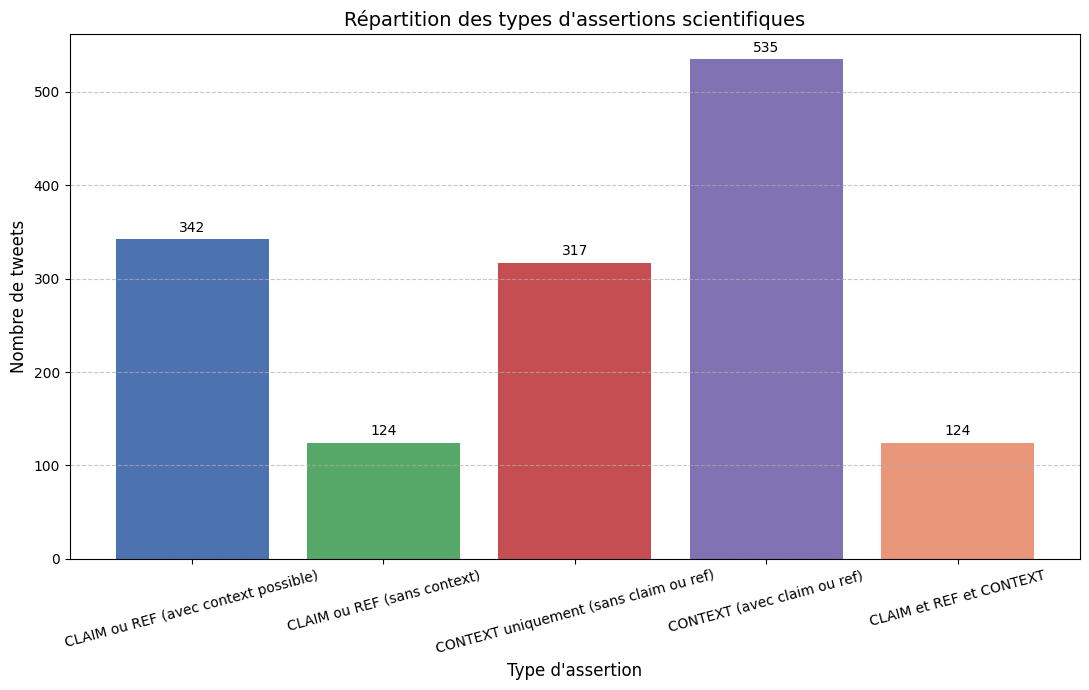


✔️ Label distribution:
label
1    342
0    317
Name: count, dtype: int64
🧹 Nettoyage avancé + lemmatisation...
🔢 Taille TF-IDF : (659, 1323)
➕ Taille features binaires : (659, 3)
📐 Taille finale : (659, 1326)
🧼 Matrice nettoyée : (659, 988)

=== Training Models ===


In [ ]:
##### if __name__ == "__main__":
    main()